# **Lab 5 Concept-based Explainable AI**



---





**Teaching assistant**: Eleonora Poeta ( eleonora.poeta@polito.it )

**Lab 5**: Concept-based XAI - CRAFT

# **CRAFT**



[CRAFT](https://arxiv.org/pdf/2211.10154) is a novel **concept-based method** explainable by-design.

It does the **automated extraction** of high-level **concepts** that neural networks have learned.

It has the following key attributes:

* **Multi-Layer Concept Extraction**: It allows for the extraction of concepts from *various locations within the model*, thus enabling the identification of the **most pertinent laye**r for representing individual concepts.
*  **Concept Importance Assessment**: CRAFT computes the **significance** of **individual** **concepts** concerning the model's predictions through the use of Sobol indices.
* **Concept Attribution Map**: It allows to backpropagate concept scores into the pixel space, leading to "concept attribution heatmaps" generation.

**Quick Overview of CRAFT Approach**

A CRAFT investigation involves the following steps:

1. **Input images selection**: Select a set of images ***X*** from the dataset where the model's predictions align with the class under investigation.

2. **Layer Selection**: Choose a layer to initiate the investigation, and split the model into 2 parts at this location: the 1st part ***g*** computes the activations of our input images, while the 2nd part ***h*** computes the logits.<br> **CRAFT will extract concepts from the activation space of this selected layer.**

3. **CRAFT Fitting**:
 * **Crops Extraction**: CRAFT automatically **extracts random image crops** from the input dataset. This choice is motivated by the expectation that concepts are present in these crops, and can be subsequently dissected. CRAFT will operate on these crops to factorize the concepts. These crops are also used to visualize the concepts.

 * **Concept Activation Factorization**: In this phase, we use the 1st model ***g*** to compute the random crops activations, and then apply a Non-negative Matrix Factorization (NMF) to decompose these positive activations into two matrices:
  >* W constitutes a dictionary of Concept Activation Vectors (CAVs). It can be understood as a "concept basis" or "concept bank",
  >* U represents the concept values, which are coefficients allowing to redefine the data points in our dataset according to the concept basis

5. **Concept Importance Estimation**: **Sensitivity** analysis is employed to estimate the global importance of each concept across the entire dataset.

  * **In general**, the **Sensitivity** measures the degree to which a model's output or predictions are influenced by changes or perturbations in specific features or concepts.
  * CRAFT uses Sobol indices to measure the contribution of each concept on the model's output.
  * Once this step is achieved, it is possible to compute the **contribution of each concept for a specific image**, thus capturing its local importance. CRAFT provides a variety of plotting functions to showcase the concepts and their respective importance.

6. Visualization of **Concept Map Attribution** : CRAFT has the ability to generate concept-wise attribution maps. These maps display the **part of an image that triggered the detection of the concept** by the network.



---

# **Exercise 1**



To implement CRAFT you have to refer to **[Xplique](https://github.com/deel-ai/xplique)** library available on Github.

This library is composed of different modules:
  * The *Concepts* module allows you to extract human concepts from a model and to test their usefulness with respect to a class.



---


**Steps** to follow:



0.   Select the **GPU Runtime**.
1.   Install the **Xplique library** running the given commands.
2.   **Download the data**. You will download the class of rabbits. Run the given command
3.   
.   **CRAFT** requires splitting the model in two parts.
So, you have to prepare  two functions $(g, h)$ such that $f(x) = (g \cdot h)(x)$.

  * **$g$** is the function that maps our input to the latent space (the penultimate layer of our model).
  > * As **$g$** you will use the **ResNet50** from `torchvision.models
  > * **$g$** will be `'input_to_latent'` part. We need to take the *first 8 layers* of the ResNet50.

  * **$h$** is the function that maps from the layer before the classification head to the output.
   > * **$h$** will be `'latent_to_logit'` part.
   > You will implement this classifier head (follow the instruction in the comments of the cell)

4. Define **transformation for the image** data from `torchvision.transforms`. You have to:
  * Transform the np array to a **PIL Image**
  * **Resize** the image up to 256
  * **CentreCrop** it to 256
  * Trasform the PIL Image to a **tensor**
  * **Normalize** the image with the given values

5. **Instanciate CRAFT**
6. **Fit** CRAFT
7. Calculate (global) **concept importances**
8. **Plot** some visualizations





> N.B: Check the documentation at this [link](https://deel-ai.github.io/xplique/latest/api/concepts/craft/) .




## Solution:

#### Imports

In [1]:
# Install Xplique
!pip install -q xplique

^C



[notice] A new release of pip is available: 23.3.1 -> 24.0
[notice] To update, run: python.exe -m pip install --upgrade pip


In [ ]:
# Get some rabbit images
!curl -O https://share.deel.ai/s/fq78w4E2GTrQ54S/download && mv download rabbit.npz

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed

  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
  4 43.0M    4 2016k    0     0  1313k      0  0:00:33  0:00:01  0:00:32 1315k
 25 43.0M   25 11.1M    0     0  4530k      0  0:00:09  0:00:02  0:00:07 4532k
 42 43.0M   42 18.4M    0     0  5362k      0  0:00:08  0:00:03  0:00:05 5364k
 55 43.0M   55 23.8M    0     0  5413k      0  0:00:08  0:00:04  0:00:04 5415k
 65 43.0M   65 28.3M    0     0  5269k      0  0:00:08  0:00:05  0:00:03 5809k
 77 43.0M   77 33.3M    0     0  5238k      0  0:00:08  0:00:06  0:00:02 6444k
 90 43.0M   90 38.8M    0     0  5293k      0  0:00:08  0:00:07  0:00:01 5676k
100 43.0M  100 43.0M    0     0  5319k      0  0:00:08  0:00:08 --:--:-- 5288k
'mv' is not recognized as an internal or external c

In [2]:
import torch
import torchvision.models as models
import torch.nn as nn
import numpy as np

In [3]:
# Check the device you are using is cuda
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [4]:
# Load a ResNet model from torchvision.models
# Complete with your code
device = torch.device('cuda')
model = models.resnet50(pretrained=True).to(device)


c:\Users\a_h9\AppData\Local\Programs\Python\Python311\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\a_h9\AppData\Local\Programs\Python\Python311\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [5]:
# Cut the model in two part, g and h

# g is our 'input_to_latent'. For ResNet18 you have to take the first 8 layers
g = nn.Sequential(*(list(model.children())[:8]))

In [6]:
print(g)

Sequential(
  (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU(inplace=True)
  (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (4): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)


In [7]:
# h is our 'latent_to_logit'
# Complete with your code

h = nn.Sequential(
    nn.AdaptiveAvgPool2d((1,1)), # AdaptiveAvgPool2d(1,1)
    nn.Flatten(), # Flatten
    nn.Dropout(0.0), # Dropout with p=0.0
    nn.Linear(2048,1000), # Linear with in_features=2048, out_features=1000
    nn.Identity(), # Identity
  )


h = h.to(device)

In [8]:
print(h)

Sequential(
  (0): AdaptiveAvgPool2d(output_size=(1, 1))
  (1): Flatten(start_dim=1, end_dim=-1)
  (2): Dropout(p=0.0, inplace=False)
  (3): Linear(in_features=2048, out_features=1000, bias=True)
  (4): Identity()
)


In [9]:
# Define tranformation for our image data
# Complete with your code !

import torchvision.transforms as transforms

transf = transforms.Compose([
    transforms.ToPILImage(), # ToPILImage
    transforms.Resize(256), # Resize
    transforms.CenterCrop(256), # CenterCrop
    transforms.ToTensor(), # ToTensor
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]) # Normalize

])

In [22]:
rabbit_class = 330 # imagenet class for rabbit

# loading some images of rabbits !
images = np.load('rabbit.npz')['arr_0'].astype(np.uint8)

images_preprocessed = torch.stack([transf(img) for img in images], 0)

images_preprocessed = images_preprocessed.to(device)

images_preprocessed.shape

torch.Size([300, 3, 256, 256])

Fitting CRAFT: Patches Creation and Concepts Factorization

In [23]:
from xplique.concepts import CraftTorch as Craft
from xplique.concepts import DisplayImportancesOrder


# Complete with your code !

# Instanciate CRAFT
craft = Craft(input_to_latent_model = g,
              latent_to_logit_model = h,
              number_of_concepts = 10,
              patch_size = 80,
              batch_size = 64,
              device = device)

In [24]:
# now we can start fit the concept using our rabbit images
# CRAFT will:
# 1. Create the patches
# 2. Find the concepts
# 3. Return the crops (crops), the embedding of the crops (crops_u), and the concept bank (concept_bank_w)
crops, crops_u, concept_bank_w = craft.fit(images_preprocessed, # images preprocessed
                                           class_id=0) # id of the class of rabbit

crops.shape, crops_u.shape, concept_bank_w.shape

c:\Users\a_h9\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\decomposition\_nmf.py:1710: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


((2700, 3, 80, 80), (2700, 10), (10, 2048))

Calculate the concept importances with Sobol score. Use the `estimate_importance()` function.

In [25]:
importances = craft.estimate_importance()

In [26]:
importances

array([0.08327387, 0.06369857, 0.14359319, 0.00300073, 0.00138149,
       0.02029224, 0.15829177, 0.04478236, 0.0240704 , 0.00048475],
      dtype=float32)

In [32]:
images_preprocessed[21].unsqueeze(0).cpu().numpy().transpose(0,2,3,1).shape

(1, 256, 256, 3)

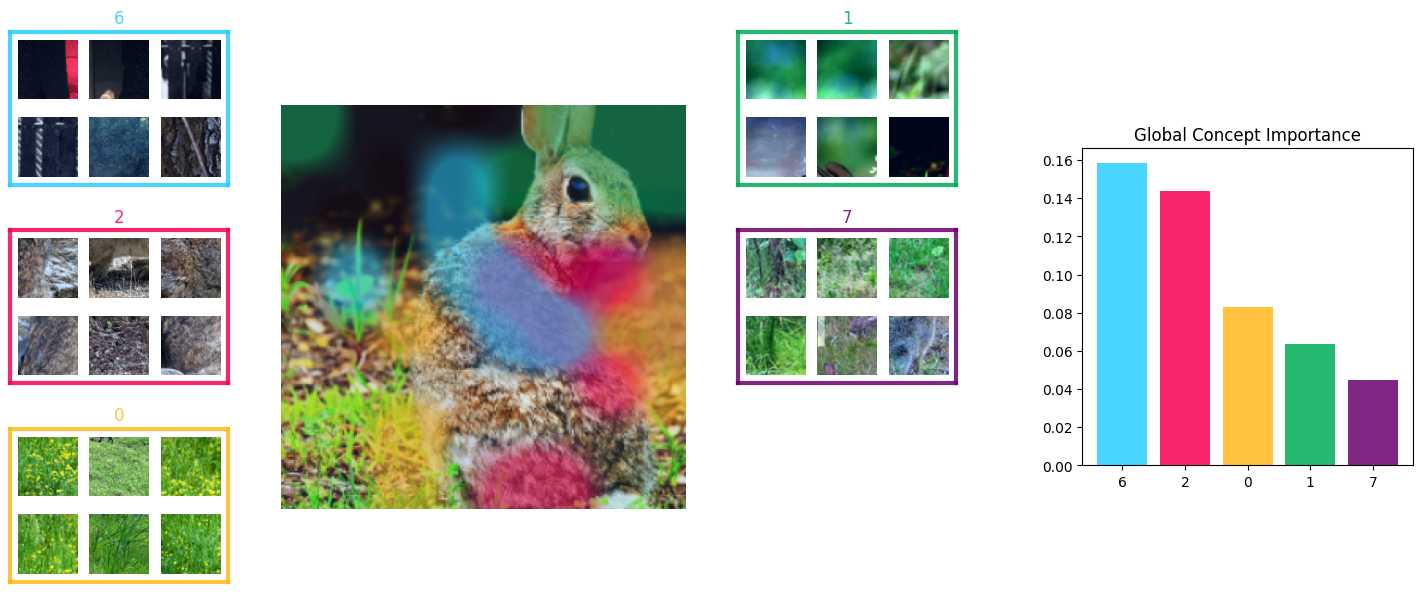

In [42]:
# Plot the attribution map for 1 image, and the concepts associated to the class around it, ordered by global importance
# Select one of the images_processed (e.g. 21 ) and put it on .cpu()

craft.plot_image_concepts(img=images_preprocessed[21].cpu())


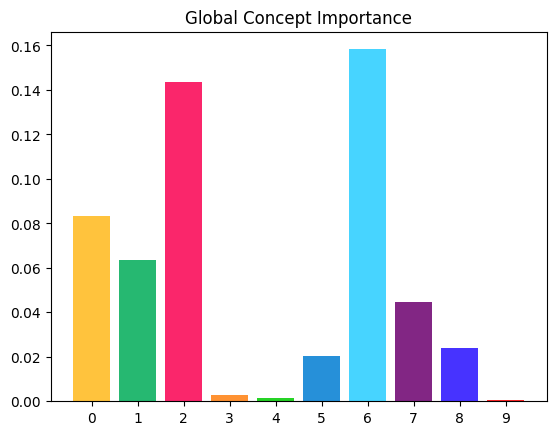

In [44]:
# Let's see which concepts matter

# Plot the importance values. Use the plot_concepts_importances()
# Complete with your code !

craft.plot_concepts_importances(importances)


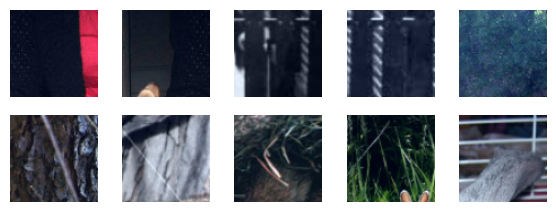

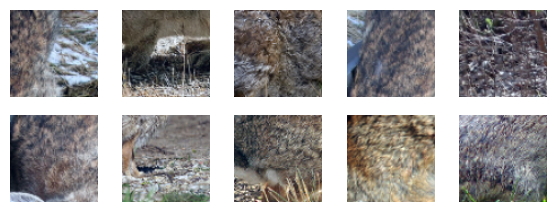

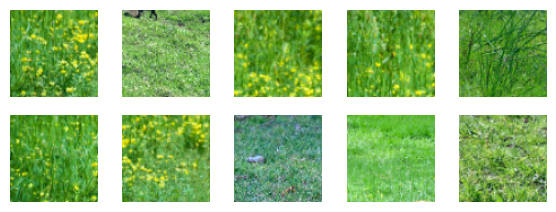

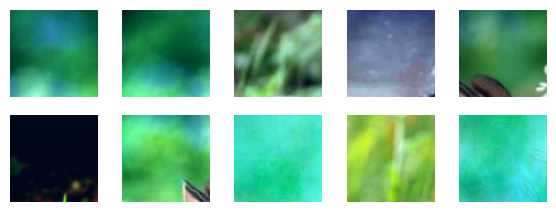

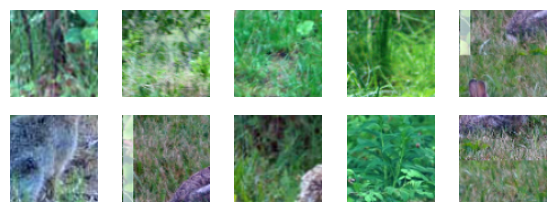

In [45]:
# Let's inspect those concepts by showing the 10 best crops for each concept.

# Limit the display to the 5 most important concepts.
craft.plot_concepts_crops(nb_crops=10, # nb_crops
                          nb_most_important_concepts=5)

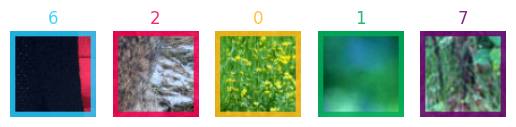

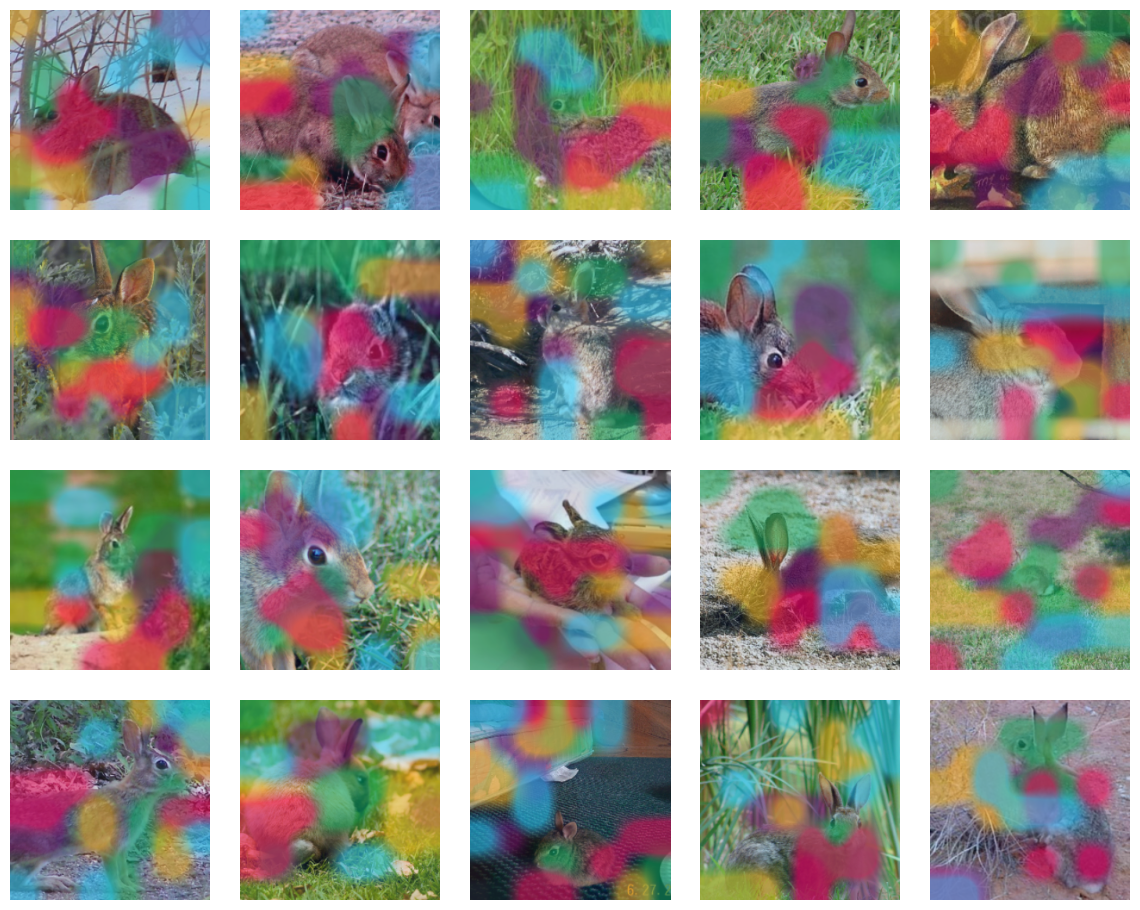

In [48]:
# Display the attribution map for the first 20 images. Remeber to put them on .cpu()

# Limit the display to the 5 most important concepts.   
craft.plot_concept_attribution_maps(images=images_preprocessed[:20].cpu(), 
                                    nb_most_important_concepts=5)